<a href="https://colab.research.google.com/github/neerajguleria1/driver-drowsiness-detection/blob/main/Day24Adv_%26_Day_25ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   Speed  Seatbelt  Alertness  Heart_rate  Fatigue  Drowsy
0     38         0   0.492647          59        6       1
1    118         1   0.377073          89        9       0
2    115         1   0.799115          71        5       0
3    127         1   0.537501          99        2       1
4    149         1   0.648259          86        8       1
(2000, 6)
Accuracay: 58.33%
Precision: 50.83%
Recall: 48.03%
F1: 49.39%


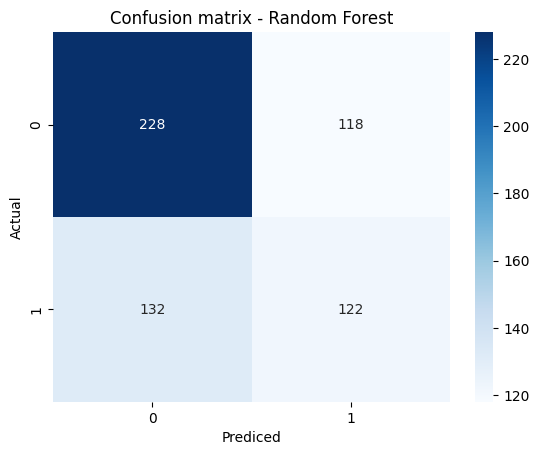

[0.5575 0.5925 0.63   0.595  0.6075]
mean score 59.65 %
std dev: 2.36 %


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_score,recall_score,f1_score
n=2000
speed=np.random.normal(120,40,n).clip(30,250)# average speed is 120 and std speed is 40 from n and varies from 30 to 250
seatbelt=np.random.choice([0,1],size=n,p=[0.3,0.7])# seatbelt means 0 is no and 1 is yes 30% is wearing and 70 is not
alertness=np.random.uniform(0.1,1.0,n)# human are not fully inactive or fully active so we take from 0.1 to 1
heart_rate=np.random.normal(80,15,n).clip(50,150)# average heart rate is 80 and variation is 15 which means it go upper and higher and limit lower limit is 50 and upper 150
fatigue=np.random.randint(0,11,n)# fatigue means 0 is full fresh and 10 is extremely tired

drowsy_prob=(
    (1-alertness)*0.5+ # what this means: it defines if alertness define 50% probability
    (fatigue/10)*0.4+ # if driver is tired it defines 40%
    (speed>160)*0.1 # and if speed goes 160 id defines 10% probability
)

# Now we have to convert to 0 or 1
drowsy=np.random.binomial(1,drowsy_prob.clip(0,1)) # this created realastic pattern that ml can learn

df=pd.DataFrame({
    'Speed':speed.astype(int),
    'Seatbelt':seatbelt,
    'Alertness':alertness,
    'Heart_rate':heart_rate.astype(int),
    'Fatigue':fatigue,
    'Drowsy':drowsy
})

print(df.head())
print(df.shape)
df.to_csv("driver drowsiness_dataset.csv",index=False)

# Now we train and test split
X=df[['Speed','Alertness','Seatbelt','Heart_rate','Fatigue']]
y=df['Drowsy']

X_train,X_test,y_train,y_test=train_test_split(
    X,y,test_size=0.3,random_state=42
)

model=RandomForestClassifier(n_estimators=200,random_state=42)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

acc=accuracy_score(y_test,y_pred)
prec=precision_score(y_test,y_pred)
rec=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)

print(f"Accuracay: {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"Recall: {rec*100:.2f}%")
print(f"F1: {f1*100:.2f}%")

cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')# annot true means we cam see numbers and fmt d means decimal integer
plt.title("Confusion matrix - Random Forest")
plt.xlabel("Prediced")
plt.ylabel("Actual")
plt.show()

kfold=KFold(n_splits=5,shuffle=True,random_state=42)
cv_score=cross_val_score(model,X,y,cv=kfold,scoring='accuracy')

print(cv_score)
print(f"mean score",round(cv_score.mean()*100,2),"%")
print(f"std dev:",round(cv_score.std()*100,2),"%")
df.to_csv("driver_drowsiness_detection.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2000 non-null   int64  
 1   Speed       2000 non-null   int64  
 2   Seatbelt    2000 non-null   int64  
 3   Alertness   2000 non-null   float64
 4   Heart_rate  2000 non-null   int64  
 5   Fatigue     2000 non-null   int64  
 6   Drowsy      2000 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 109.5 KB
None
Unnamed: 0    0
Speed         0
Seatbelt      0
Alertness     0
Heart_rate    0
Fatigue       0
Drowsy        0
dtype: int64


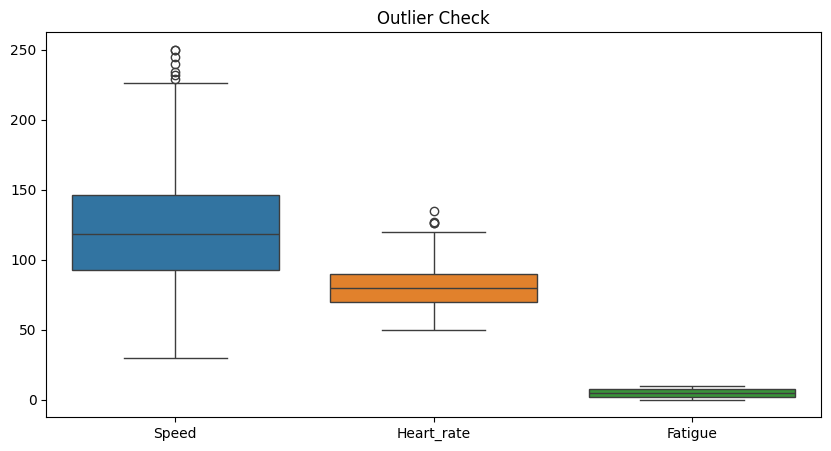

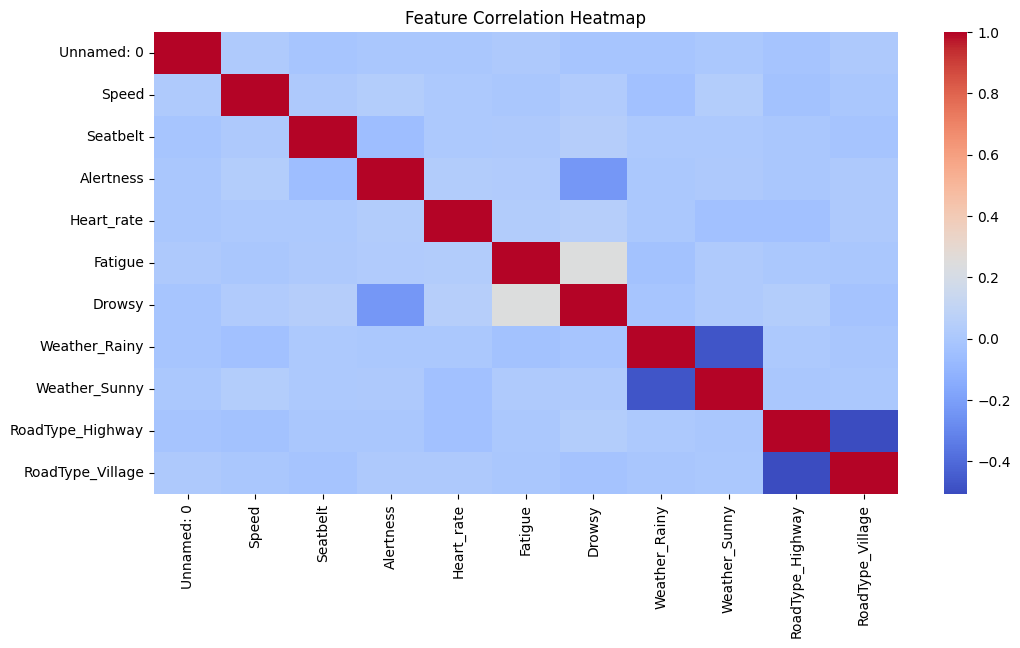

Accuracy: 61.00
            Feature  Importance
3         Alertness    0.241409
0        Unnamed: 0    0.181163
1             Speed    0.170793
4        Heart_rate    0.156766
5           Fatigue    0.137169
2          Seatbelt    0.025478
7     Weather_Sunny    0.022480
8  RoadType_Highway    0.022328
6     Weather_Rainy    0.021579
9  RoadType_Village    0.020834


In [32]:
# Day 26
''' Today we perform Scaling like standardScaler, MinMaxScaler
Endcoding: OneHotEncoding, LabelEncoding
Feature Selection: Correlation, Importance Ranking
Outlier Detection
Pipeline
Today after this our model becomes faster, more accurate and more stable'''

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df=pd.read_csv("driver_drowsiness_detection.csv")

# Now we check data types
print(df.info()) # it show data types and its very important for scaling and encoding
print(df.isnull().sum()) # and this one shows missing values

# In this we handle missing values
''' why we do this, if our dataset has no missing values
but we have must always write missig value handlin code.
Because in real world projects, data is never clean.'''

df=df.fillna(df.mean(numeric_only=True))

# Now the most important thing we do like real engineer do
''' Outlier Detection & Handling : Out synthetic dataset can still contain
extreme values because of the distribution. We need to fix them.

# Our 4 step is Visualize Outlier with Boxplots '''
plt.figure(figsize=(10,5))
sns.boxplot(data=df[['Speed','Heart_rate','Fatigue']])
plt.title("Outlier Check")
plt.show()
''' Why this matters:
    Outliers Destroy ML model Stability
    We see extreme spikes visually
    Boxplot is the fastest way to detect them
    Helps us to debug quality '''


# Step 5 is Handle Oulier
''' Now we clip extreme values in outlier range'''
df['Speed']=np.clip(df['Speed'],30,240)
df['Heart_rate']=np.clip(df['Heart_rate'],50,140)

# Step 6 Now we Add Categorial Feature
df['Weather']=np.random.choice(['Sunny','Rainy','Foggy'],size=len(df))
df['RoadType']=np.random.choice(['Highway','City','Village'],size=len(df))
''' Weather affects: Foggy: higher drowsy chance, Rainy: more stress
RoadType: Highway: Higher Speed, City: more stop & go,  Village: Uneven Roads'''


# Step 7 One Hot Encode the Categorical Feature
df_encoded=pd.get_dummies(df,columns=['Weather','RoadType'],drop_first=True)
''' drop_first=True is used for avoid dummy varuiable trap'''


# Step 8 Feature Correlation Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df_encoded.corr(),cmap="coolwarm",annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# Step 9 Now we Extract Features and target
''' Our encoded dataset now has Many columns, including:
numerical features, one-hot encoded weather,one-hot encoded road type and target column
we have to seprate them cleanly'''
X=df_encoded.drop('Drowsy',axis=1)
y=df_encoded['Drowsy']
''' ML modes need X(featues) and y(labels), dropping drowsy prevent leakage
all encoded columns are included automatically and now this prepares our dataset for training'''

# Step 10 In this we Split the data for training and testing
X_train,X_test,y_train,y_test=train_test_split(
    X,y,test_size=0.3,random_state=42
)

# Step 11 We Build a Machine Learnin Pipeline
'''  A Pipeline is how real-world ML system are written
It ensures: clean preprocessing, Automatic Scaling, Autmatic model training
Now messy code, no manual mistake  and ready for deployment
We will use: StandardScaler for scaling and RandomForestClassifier for prediction'''

from sklearn.pipeline import Pipeline
pipeline=Pipeline([
    ('scaler',StandardScaler()),
    ('model',RandomForestClassifier(n_estimators=200,random_state=42))
])
''' This scaler is only applied only to training data , and same is used to automatically
on test data, eveything becomes modular and clean, future model changes becomes super easy'''

# Step 12 Now we train the pipeline
''' Now we fit the pipeline on our training data.
This will : scale the data, train the randomForest, and stores everyting a single clean pipeline'''
pipeline.fit(X_train,y_train)
y_pred=pipeline.predict(X_test)
''' When we run pipeline.fit():
StandardScaler learns the scaling from X_train and X_train get scales and RandomForstTrain in scaled on X_train
And when we run pipeline.predict():
StandardScaler scales X_test (using same stats from training)
RandmoForst predict on scaled X_test'''

# Step 13 Now we Evalute Model Performance
accuracy=accuracy_score(y_test,y_pred)
print(f"Accuracy: {accuracy*100:.2f}")

# Step 24 Feature Importance
''' Pipeline hideds the model inside, so we extract like this:'''
importances=pipeline.named_steps['model'].feature_importances_

feature_importances=pd.DataFrame({
    'Feature':X_train.columns,
    'Importance':importances
}).sort_values(by='Importance',ascending=False)
print(feature_importances)